<h1>Image Classification</h1>

This notebook develops code for a single class classificaction problem based on the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset following the text [Hands-On Machine Learning](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).

The dataset contains images of handwritten digits, and the goal is to classify this images into 2 classes and analyze the metrics of the model.

The data is loaded using sklearn.

<h3>Libraries</h3>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier

In [3]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X

NameError: name 'mnist' is not defined

In [4]:
y = y.astype(np.uint8)
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: uint8

We have 70.000 images, each image has 784 features, this is because the original 28x28 pixels of each image are flatten to a 784-dimensional vector. Is important to note that that each pixel ranges from 0(white) to 255(black).

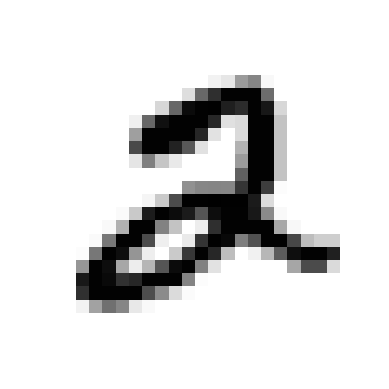

2

In [5]:
exmpl_data = X.iloc[5]
exmpl_data_reshaped = exmpl_data.values.reshape(28, 28)
plt.imshow(exmpl_data_reshaped, cmap=plt.cm.binary)
plt.axis("off")
plt.show()
y[5]

The label correspond to the image.

<h3>Train-Test Split</h3>
The dataset is already shuffled and the first 60.000 images are used for training, the remaining images are used for testing.

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

<h3>Training</h3>
Initially we are going to make a classifier that only detects if an image is a two or not a two. The model is going to be a Stochastic Gradient Descent (SGD) classifier.

In [7]:
y_train_2 = y_train == 2
y_test_2 = y_test == 2



In [8]:
sgdc=SGDClassifier(random_state=0)
sgdc.fit(X_train, y_train_2)

SGDClassifier(random_state=0)

Now we use the example showed before to see what the model predicts.

In [9]:
sgdc.predict([exmpl_data])

c:\Users\cozie\MNIST\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

The prediction is correct.
<h3>Scoring</h3>

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgdc,X_train,y_train_2,cv=3,scoring='accuracy')

array([0.9607 , 0.96765, 0.97255])

The accuracy is above 96%, that's because the dataset is skewed.

Text(0, 0.5, '')

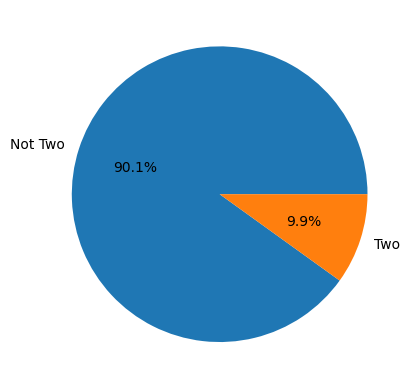

In [11]:
y_train_2.value_counts().plot.pie(labels=['Not Two','Two'],autopct='%1.1f%%')
plt.ylabel('')

Let's use a better performance metric such as Confusion Matrix

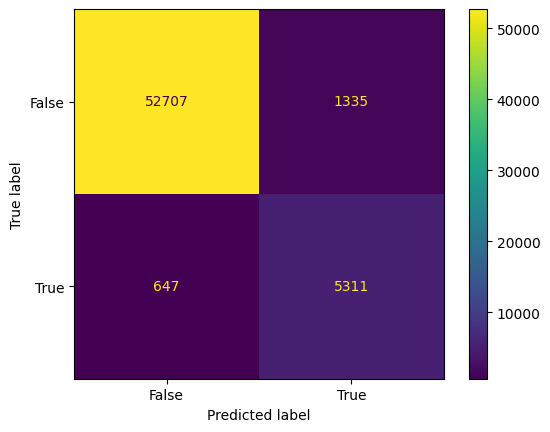

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgdc, X_train, y_train_2, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train_2, y_train_pred)

Precision $\frac{TP}{TP+FP}$

Recall $\frac{TP}{TP+FN}$

In [13]:
from sklearn.metrics import precision_score, recall_score

print('Precision: ', precision_score(y_train_2,y_train_pred))
print('Recall: ', recall_score(y_train_2,y_train_pred))

Precision:  0.7991272946133012
Recall:  0.8914065122524337


F1 score $\frac{TP}{TP+\frac{FN+FP}{2}}$

In [14]:
from sklearn.metrics import f1_score

print('F1: ', f1_score(y_train_2, y_train_pred))

F1:  0.8427483338622659


So our model is not that perfect when using other metrics.

Let's see the precision/recall curve for different thresholds.

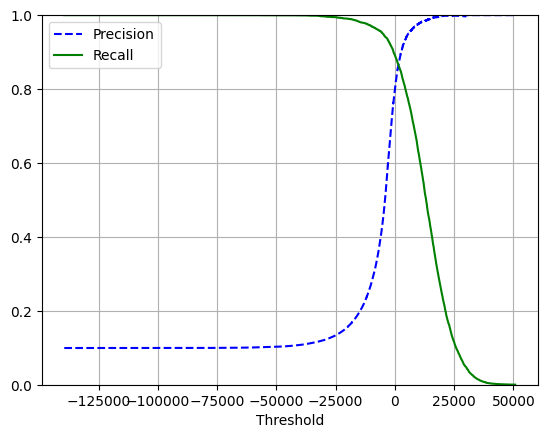

In [15]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgdc,X_train, y_train_2, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_2, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.grid(True)
    plt.legend()
    plt.xlabel('Threshold')
    plt.ylim((0,1))

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Now we use ROC curve:

In [16]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_2, y_scores) #computes false and true positive rates for different thresholds

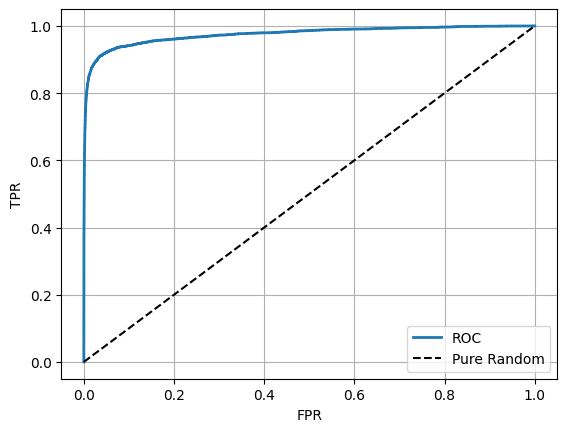

In [17]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--',label='Pure Random')
    plt.grid(True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()

plot_roc_curve(fpr,tpr,'ROC')
plt.show()

Area under the curve of our ROC.

In [18]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_2,y_scores)

0.9750212337801143

Compare with a Random Forest classifier.

In [19]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=0)
y_prob_forest = cross_val_predict(forest, X_train, y_train_2, cv=3, method='predict_proba')

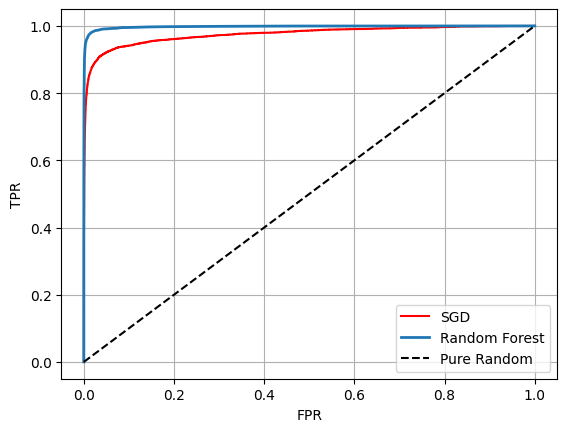

In [23]:
y_scores_forest = y_prob_forest[:,1] 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_2,y_scores_forest)

plt.plot(fpr, tpr, "r-", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()


In [24]:
roc_auc_score(y_train_2, y_scores_forest)

0.9977082182881667

Random Forest performs better than SGD.